In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.utils import fill_infos

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(294697)

***
# Data import

In [3]:
chunk_size = 100000
sample_size_percent = 5

data = pd.DataFrame()

for chunk in pd.read_csv("./datas/en.openfoodfacts.org.products.csv", sep="\t", nrows=None, chunksize=chunk_size):
    actual_chunk_size = chunk.shape[0]
    random_size = int(actual_chunk_size * (sample_size_percent / 100))
    random_indexes = np.random.default_rng().choice(chunk.index, size=random_size, replace=False)
    chunk = chunk.loc[random_indexes]
    data = pd.concat([data, chunk])
    del chunk

data.shape

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,27,28,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,8,13,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_as

(95365, 186)

## Dataset overview

In [4]:
rows_nb, cols_nb = data.shape

In [5]:
data.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
55254,27271115288,http://world-en.openfoodfacts.org/product/0027...,usda-ndb-import,1489071016,2017-03-09T14:50:16Z,1592670571,2020-06-20T16:29:31Z,Dijon honey mustard dressing,NaN,NaN,NaN,NaN,NaN,NaN,Del Sol Food Company Inc.,del-sol-food-company-inc,"Groceries, Condiments, Sauces, Mustards, Dijon...","en:groceries,en:condiments,en:sauces,en:mustar...","Groceries,Condiments,Sauces,Mustards,Dijon mus...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States,"canola oil, water, dijon mustard (vinegar, mus...",NaN,NaN,NaN,NaN,NaN,2 Tbsp (30 ml),30.0,NaN,4.0,NaN,"en:e306,en:e330,en:e334,en:e415","E306 - Tocopherol-rich extract,E330 - Citric a...",0.0,NaN,NaN,0.0,NaN,NaN,20.0,e,4.0,Fat and sauces,Dressings and sauces,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete.

***
# Feature analysis

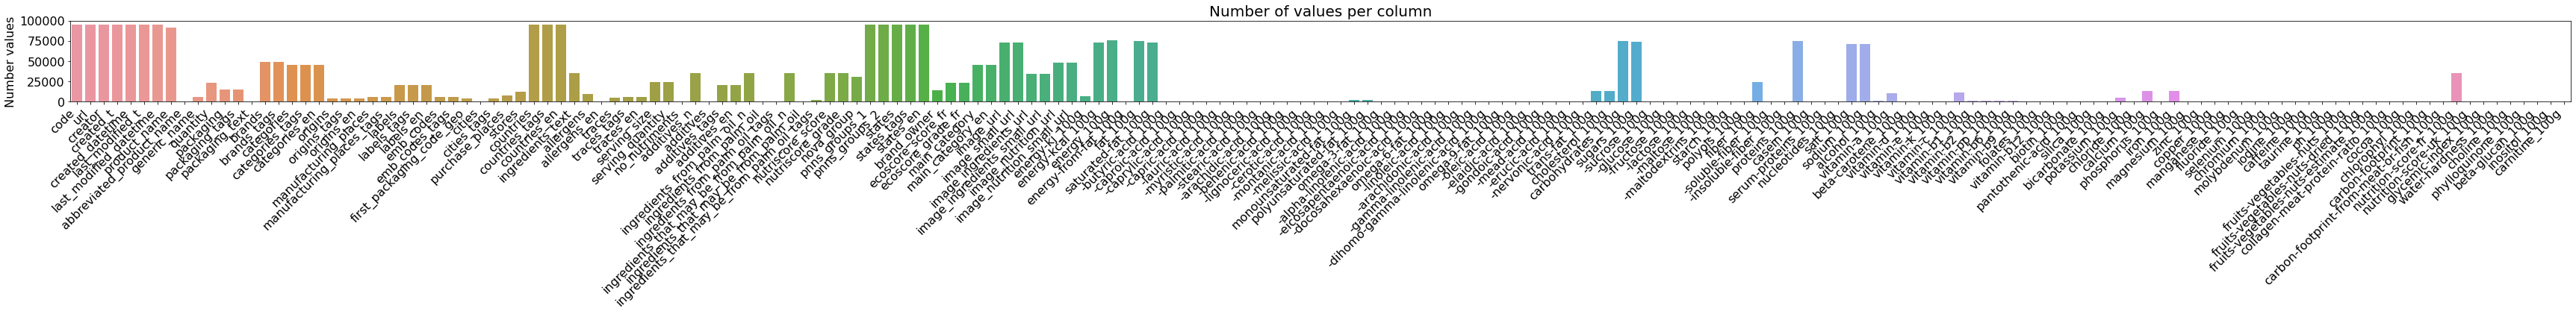

In [136]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data.columns, y=data.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [7]:
features = []

## General informations

In [8]:
general_infos = data.loc[:, "code":"quantity"]

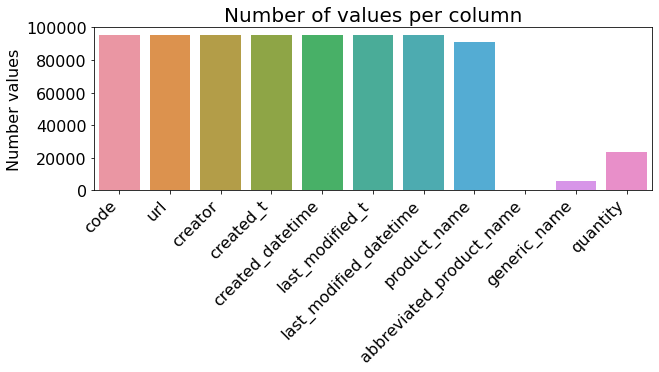

In [9]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos.columns, y=general_infos.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [10]:
general_infos.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity
55254,27271115288,http://world-en.openfoodfacts.org/product/0027...,usda-ndb-import,1489071016,2017-03-09T14:50:16Z,1592670571,2020-06-20T16:29:31Z,Dijon honey mustard dressing,NaN,NaN,NaN
29432,16229910594,http://world-en.openfoodfacts.org/product/0016...,elcoco,1559126788,2019-05-29T10:46:28Z,1604411302,2020-11-03T13:48:22Z,Vermicelles de Riz,NaN,NaN,NaN
4008,0009542005443,http://world-en.openfoodfacts.org/product/0009...,org-database-usda,1587655568,2020-04-23T15:26:08Z,1587655569,2020-04-23T15:26:09Z,Milk chocolate with a hazelnut and caramel bro...,NaN,NaN,NaN
9814,11110863676,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489077842,2017-03-09T16:44:02Z,1587589242,2020-04-22T21:00:42Z,Breakfast Bread,NaN,NaN,NaN
21035,13400022862,http://world-en.openfoodfacts.org/product/0013...,org-database-usda,1587663593,2020-04-23T17:39:53Z,1587663593,2020-04-23T17:39:53Z,Enriched parboiled long grain rice,NaN,NaN,NaN


In [11]:
general_infos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   code                      95365 non-null  object
 1   url                       95365 non-null  object
 2   creator                   95365 non-null  object
 3   created_t                 95365 non-null  int64 
 4   created_datetime          95365 non-null  object
 5   last_modified_t           95365 non-null  int64 
 6   last_modified_datetime    95365 non-null  object
 7   product_name              91339 non-null  object
 8   abbreviated_product_name  356 non-null    object
 9   generic_name              5886 non-null   object
 10  quantity                  23718 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


### Redundancy: product_name, abbreviated_product_name, generic_name

In [12]:
general_infos[general_infos.generic_name.notna()].product_name.isna().sum()

10

We can see that 'abbreviated_product_name' contains too fews entries to be usefull.  
Regarding the 'generic_name', the fill percentage is not very high, but worst, each time 'generic_name' is filled, so is 'product_name'.

#### Conclusion
Only 'product_name' feature is usefull

In [13]:
general_infos_features = [
    "code",
    "url",
    "creator",
    "created_t",
    "created_datetime",
    "last_modified_t",
    "last_modified_datetime",
    "product_name",
    "quantity"
]

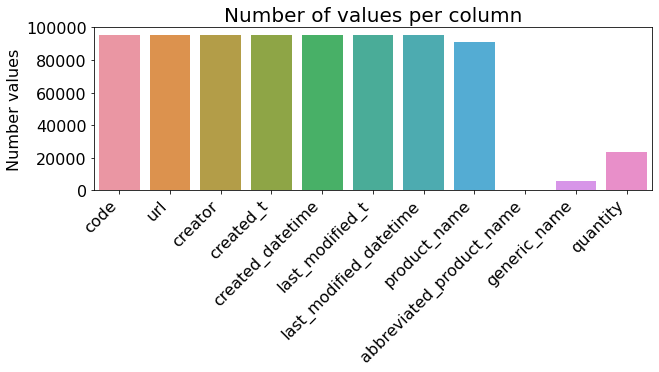

In [14]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos.columns, y=general_infos.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

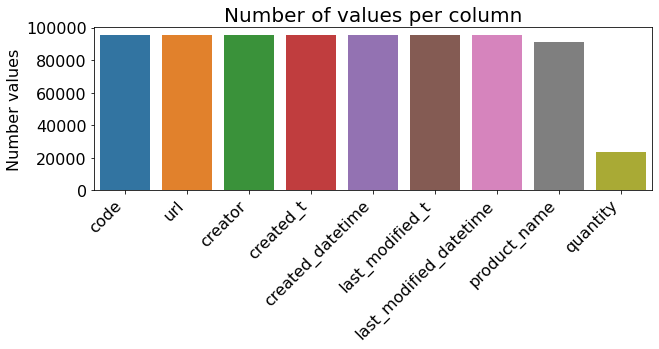

In [15]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos[general_infos_features].columns, y=general_infos[general_infos_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

## Tags

In [16]:
tags = data.loc[:, "packaging":"countries_en"]

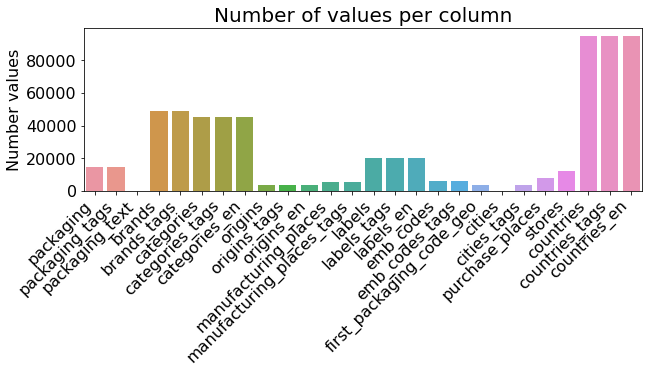

In [17]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=tags.columns, y=tags.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [18]:
tags.head()

,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en
55254,NaN,NaN,NaN,Del Sol Food Company Inc.,del-sol-food-company-inc,"Groceries, Condiments, Sauces, Mustards, Dijon...","en:groceries,en:condiments,en:sauces,en:mustar...","Groceries,Condiments,Sauces,Mustards,Dijon mus...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States
29432,NaN,NaN,NaN,Aroy-D,aroy-d,"Alimentos y bebidas de origen vegetal, Aliment...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:spain,en:spain,Spain
4008,NaN,NaN,NaN,NaN,NaN,"Snacks, Sweet snacks, Confectioneries","en:snacks,en:sweet-snacks,en:confectioneries","Snacks,Sweet snacks,Confectioneries",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States
9814,NaN,NaN,NaN,Private Selection,private-selection,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States
21035,NaN,NaN,NaN,NaN,NaN,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States


In [19]:
tags.iloc[:, :13].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   packaging                  14939 non-null  object
 1   packaging_tags             14937 non-null  object
 2   packaging_text             252 non-null    object
 3   brands                     48975 non-null  object
 4   brands_tags                48969 non-null  object
 5   categories                 45136 non-null  object
 6   categories_tags            45136 non-null  object
 7   categories_en              45136 non-null  object
 8   origins                    4020 non-null   object
 9   origins_tags               4017 non-null   object
 10  origins_en                 4017 non-null   object
 11  manufacturing_places       5892 non-null   object
 12  manufacturing_places_tags  5890 non-null   object
dtypes: object(13)
memory usage: 10.2+ MB


In [20]:
tags.iloc[:, 13:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   labels                    20438 non-null  object 
 1   labels_tags               20438 non-null  object 
 2   labels_en                 20438 non-null  object 
 3   emb_codes                 6025 non-null   object 
 4   emb_codes_tags            6024 non-null   object 
 5   first_packaging_code_geo  3658 non-null   object 
 6   cities                    0 non-null      float64
 7   cities_tags               3945 non-null   object 
 8   purchase_places           7787 non-null   object 
 9   stores                    12099 non-null  object 
 10  countries                 95093 non-null  object 
 11  countries_tags            95093 non-null  object 
 12  countries_en              95093 non-null  object 
dtypes: float64(1), object(12)
memory usage: 10.2+ MB


### Empty features

In [21]:
tags.packaging_text.notna().sum()

252

In [22]:
tags.cities.notna().sum()

0

#### Conclusion

We can consider the features "packaging_text" and "cities" are empty and so not usefull.

### Redundancy

packaging, packaging_tags

In [23]:
tags.loc[:, ["packaging", "packaging_tags"]].loc[tags.packaging.notna() & tags.packaging_tags.notna()].iloc[:20]

,packaging,packaging_tags
90176,plastic bag,plastic-bag
36788,Al vacío,al-vacio
37708,"en:packet, en:mixed plastic-packet","en-packet,en-mixed-plastic-packet"
51921,"frais,plastique,Carton","frais,plastique,carton"
59233,Canned,canned
65249,plastic,plastic
61770,en:card-box,en-card-box
20331,Can,can
38397,Cardboard Box,cardboard-box
38378,en:unknown,en-unknown


In [24]:
tags[tags.packaging_tags.notna()].loc[:,["packaging"]].isna().sum()

packaging    0
dtype: int64

We can see that each time one of the features "packaging" or "packaging_tags" is filled, the other is also filled.
We will keep the feature "packaging" because it transport more information, plus, it's easier to get rid of the "en:", "fr:" than "en-", because in "packaging_tags" each separator is a "-" and not in "packaging".

brands, brands_tags

In [25]:
tags.iloc[:20].loc[:, ["brands", "brands_tags"]]

,brands,brands_tags
55254,Del Sol Food Company Inc.,del-sol-food-company-inc
29432,Aroy-D,aroy-d
4008,NaN,NaN
9814,Private Selection,private-selection
21035,NaN,NaN
97812,H-E-B,h-e-b
90159,NaN,NaN
40876,NaN,NaN
59776,NaN,NaN
94983,Shoprite,shoprite


In [26]:
tags[tags.brands_tags.notna()].loc[:,["brands"]].isna().sum()

brands    1
dtype: int64

The features "brands" and "brands_tags" are almost equally filled. We will keep "brands" because this feature carry most information (spaces, capital letters...)

categories, categories_tags, categories_en

In [27]:
tags.loc[:, ["categories", "categories_tags", "categories_en"]].iloc[:20]

,categories,categories_tags,categories_en
55254,"Groceries, Condiments, Sauces, Mustards, Dijon...","en:groceries,en:condiments,en:sauces,en:mustar...","Groceries,Condiments,Sauces,Mustards,Dijon mus..."
29432,"Alimentos y bebidas de origen vegetal, Aliment...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
4008,"Snacks, Sweet snacks, Confectioneries","en:snacks,en:sweet-snacks,en:confectioneries","Snacks,Sweet snacks,Confectioneries"
9814,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
21035,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
97812,NaN,NaN,NaN
90159,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
40876,Frozen foods,en:frozen-foods,Frozen foods
59776,Snacks,en:snacks,Snacks
94983,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."


In [28]:
tags[tags.categories.notna()].loc[:,["categories_en"]].isna().sum()

categories_en    0
dtype: int64

In [29]:
tags[tags.categories_tags.notna()].loc[:,["categories_en"]].isna().sum()

categories_en    0
dtype: int64

We will keep "categories_en".

origins, origins_tags, origins_en

In [30]:
tags.loc[:, ["origins", "origins_tags", "origins_en"]].loc[tags.origins.notna() & tags.origins_tags.notna() & tags.origins_en.notna()].iloc[:20]

,origins,origins_tags,origins_en
51921,"Écosse,Royaume-Uni","en:united-kingdom,fr:ecosse","United Kingdom,fr:ecosse"
59233,United States,en:united-states,United States
65249,buckwheat from UK,en:buckwheat-from-uk,Buckwheat-from-uk
30923,Estados Unidos,en:estados-unidos,Estados-unidos
20771,United Kingdom,en:united-kingdom,United Kingdom
28487,Estados Unidos de América,en:united-states,United States
2912,England,en:england,England
21011,Germany,en:germany,Germany
28396,Estados unidos,en:estados-unidos,Estados-unidos
21359,États-Unis,en:etats-unis,Etats-unis


In [31]:
tags[tags.origins_tags.notna()].loc[:,["origins"]].isna().sum()

origins    2
dtype: int64

In [32]:
tags[tags.origins_en.notna()].loc[:,["origins"]].isna().sum()

origins    2
dtype: int64

We will keep the feature "origins"

manufacturing_places, manufacturing_places_tags

In [33]:
tags.loc[:, ["manufacturing_places", "manufacturing_places_tags"]].loc[tags.manufacturing_places.notna() & tags.manufacturing_places_tags.notna()].iloc[:20]

,manufacturing_places,manufacturing_places_tags
59233,United States,united-states
38397,United States,united-states
30923,Ciudad de México,ciudad-de-mexico
87850,Japan,japan
28487,Estados Unidos de América,estados-unidos-de-america
42192,United States,united-states
6889,USA,usa
21011,Germany,germany
23047,USA,usa
28396,Estado de México,estado-de-mexico


We will keep the feature "manufacturing_places"

labels, labels_tags, labels_en

In [34]:
tags.loc[:, ["labels", "labels_tags", "labels_en"]].loc[tags.labels.notna() & tags.labels_en.notna() & tags.labels_en.notna()].iloc[:20]

,labels,labels_tags,labels_en
90176,"Gluten-free, Kosher, Kosher-parve, en:vegan","en:vegetarian,en:gluten-free,en:kosher,en:vega...","Vegetarian,Gluten-free,Kosher,Vegan,Kosher-parve"
46513,Organic,en:organic,Organic
29943,Organic,en:organic,Organic
21381,Organic,en:organic,Organic
51921,"Point Vert, Riche en Oméga-3, Omega-3, Pêche d...","en:omega-3,en:green-dot,en:high-in-omega-3,en:...","Omega-3,Green Dot,High in Omega 3,Sustainable ..."
65249,vegan,"en:vegetarian,en:vegan","Vegetarian,Vegan"
90191,Organic,en:organic,Organic
3085,Sans sucre ajouté,en:no-added-sugar,No added sugar
6010,Verified,en:verified,Verified
47624,"Vegetariano,Vegano","en:vegetarian,en:vegan","Vegetarian,Vegan"


We will keep "labels_en"

emb_codes, emb_codes_tags

In [35]:
tags.loc[:, ["emb_codes", "emb_codes_tags"]].loc[tags.emb_codes.notna() & tags.emb_codes_tags.notna()].iloc[:20]

,emb_codes,emb_codes_tags
21011,DE NI-20137 EC,de-ni-20137-ec
57050,Tr 4165551109/11,tr-4165551109-11
2551,FSC-C002324,fsc-c002324
2743,FSC-C023337,fsc-c023337
47799,FSC-C011534,fsc-c011534
33301,LSR002US9-02,lsr002us9-02
72308,FR 14.370.001 EC,fr-14-370-001-ec
29425,FSC-C020428,fsc-c020428
92849,FSC-C012938,fsc-c012938
360,EMB 35275A,emb-35275a


We will keep "emb_codes".

countries, countries_tags, countries_en

In [36]:
tags.iloc[:20,:].loc[:,["countries", "countries_tags", "countries_en"]]

,countries,countries_tags,countries_en
55254,United States,en:united-states,United States
29432,en:spain,en:spain,Spain
4008,United States,en:united-states,United States
9814,United States,en:united-states,United States
21035,United States,en:united-states,United States
97812,en:us,en:united-states,United States
90159,United States,en:united-states,United States
40876,United States,en:united-states,United States
59776,"France, United States","en:france,en:united-states","France,United States"
94983,United States,en:united-states,United States


In [37]:
fill_infos(tags, "countries_en")

countries_en total rows:  95093
countries_en filled count:  94821
countries_en filled percentage:  3.4960661764705883


#### Conclusion
The three features are completely filled and redundant. We can then keep only one of them, the 'countries_en' feature.

In [38]:
tags_features = [
    "packaging",
    "brands",
    "categories_en",
    "origins",
    "manufacturing_places",
    "labels_en",
    "emb_codes",
    "first_packaging_code_geo",
    "cities_tags",
    "purchase_places",
    "stores",
    "countries_en"
]

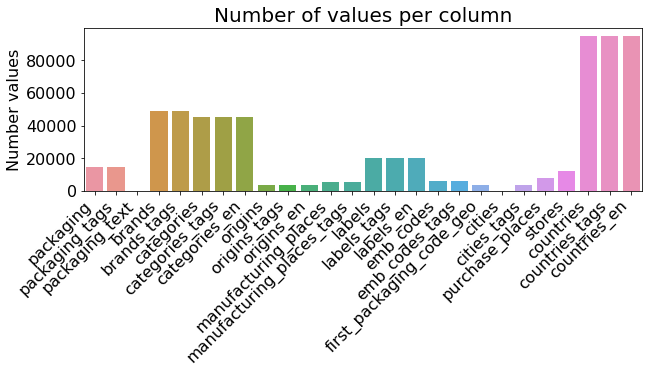

In [39]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=tags.columns, y=tags.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

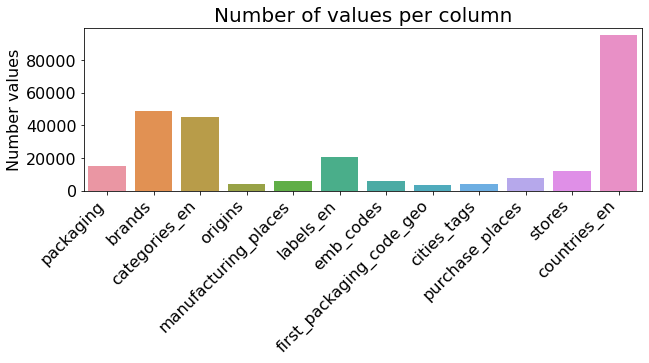

In [40]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=tags[tags_features].columns, y=tags[tags_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

## Ingredients

In [41]:
ingredients = data.loc[:, "ingredients_text":"traces_tags"]

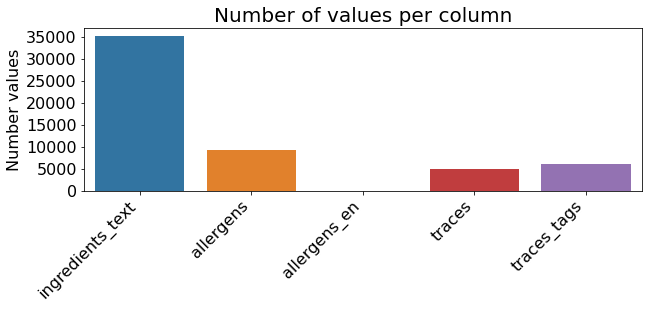

In [42]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients.columns, y=ingredients.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [43]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ingredients_text  35341 non-null  object 
 1   allergens         9306 non-null   object 
 2   allergens_en      0 non-null      float64
 3   traces            4946 non-null   object 
 4   traces_tags       6152 non-null   object 
dtypes: float64(1), object(4)
memory usage: 4.4+ MB


In [44]:
ingredients.head()

,ingredients_text,allergens,allergens_en,traces,traces_tags
55254,"canola oil, water, dijon mustard (vinegar, mus...",NaN,NaN,NaN,NaN
29432,NaN,NaN,NaN,NaN,NaN
4008,"Sugar, cocoa butter, chocolate, milk, vegetabl...","en:gluten,en:milk,en:nuts",NaN,NaN,NaN
9814,"Enriched wheat flour (wheat flour, malted barl...",NaN,NaN,NaN,NaN
21035,"Enriched parboiled long grain rice [rice, niac...",NaN,NaN,NaN,NaN


### Empty features

"allergens_en" is completely empty.

### Redundancy

traces, traces_tags

In [45]:
ingredients.loc[:, ["traces", "traces_tags"]].loc[ingredients.traces.notna() & ingredients.traces_tags.notna()].iloc[:20]

,traces,traces_tags
90176,"en:nuts,en:soybeans","en:nuts,en:soybeans"
28487,"en:gluten,es:Semilla de girasol","en:gluten,es:semilla-de-girasol"
30604,"en:gluten,en:soybeans","en:gluten,en:soybeans"
88581,en:nuts,en:nuts
27965,"en:Salt,en:baking soda,en:caramel color,en:car...","en:salt,en:baking-soda,en:caramel-color,en:car..."
86196,en:soybeans,en:soybeans
40510,"en:gluten,en:milk","en:gluten,en:milk"
64368,en:sesame-seeds,en:sesame-seeds
28396,"en:gluten,en:soybeans,es:LECHE Y HUEVO; PUEDE ...","en:gluten,en:soybeans,es:leche-y-huevo-puede-c..."
66052,"en:milk,en:Crustacean shellfish","en:milk,en:crustacean-shellfish"


There is, at first sight, no better feature. We will keep "traces"

In [46]:
ingredients_features = [
    "ingredients_text",
    "allergens",
    "traces"
]

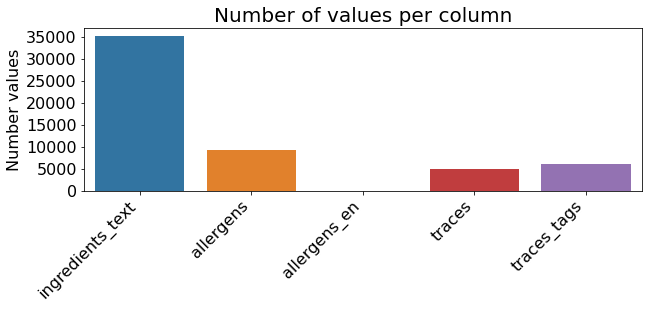

In [47]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients.columns, y=ingredients.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

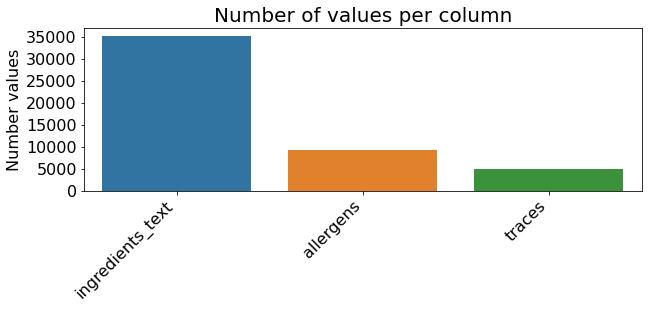

In [48]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients[ingredients_features].columns, y=ingredients[ingredients_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

## Misc datas

In [49]:
misc = data.loc[:,"serving_size":"image_nutrition_small_url"]

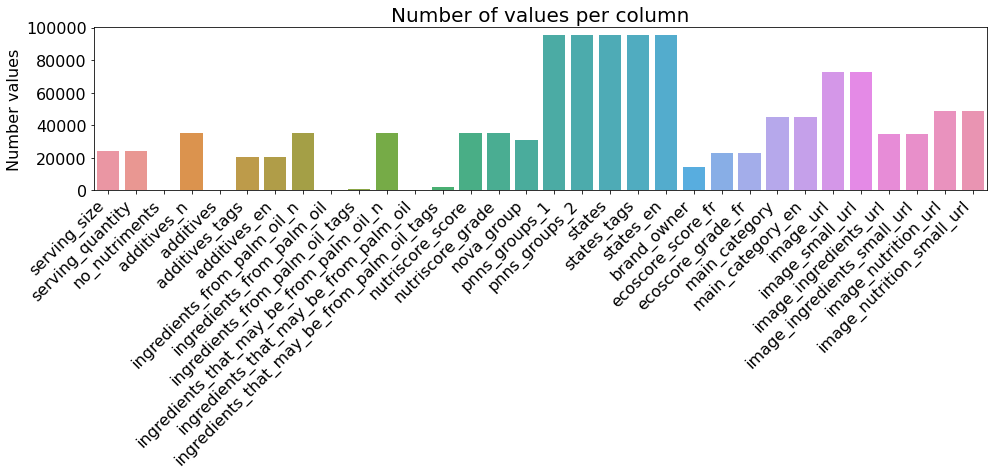

In [50]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc.columns, y=misc.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [51]:
misc.iloc[:, :16].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   serving_size                                24428 non-null  object 
 1   serving_quantity                            24226 non-null  float64
 2   no_nutriments                               0 non-null      float64
 3   additives_n                                 35341 non-null  float64
 4   additives                                   0 non-null      float64
 5   additives_tags                              20527 non-null  object 
 6   additives_en                                20527 non-null  object 
 7   ingredients_from_palm_oil_n                 35341 non-null  float64
 8   ingredients_from_palm_oil                   0 non-null      float64
 9   ingredients_from_palm_oil_tags              709 non-null    object 
 10  ingr

In [52]:
misc.iloc[:, 16:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pnns_groups_1                95350 non-null  object 
 1   pnns_groups_2                95350 non-null  object 
 2   states                       95365 non-null  object 
 3   states_tags                  95365 non-null  object 
 4   states_en                    95365 non-null  object 
 5   brand_owner                  14471 non-null  object 
 6   ecoscore_score_fr            23179 non-null  float64
 7   ecoscore_grade_fr            23179 non-null  object 
 8   main_category                45136 non-null  object 
 9   main_category_en             45136 non-null  object 
 10  image_url                    72652 non-null  object 
 11  image_small_url              72652 non-null  object 
 12  image_ingredients_url        34700 non-null  object 
 13  image_ingr

In [53]:
misc.head(1)

,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url
55254,2 Tbsp (30 ml),30.0,NaN,4.0,NaN,"en:e306,en:e330,en:e334,en:e415","E306 - Tocopherol-rich extract,E330 - Citric a...",0.0,NaN,NaN,0.0,NaN,NaN,20.0,e,4.0,Fat and sauces,Dressings and sauces,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...","Del Sol Food Company, Inc.",55.0,c,en:dijon-mustards,Dijon mustards,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...


### Empty features

These features are competely empty and then will be no needed:
- no_nutriments
- additives
- ingredients_from_palm_oil
- ingredients_that_may_be_from_palm_oil

These features are almost empty, we will get rid of them too:
- ingredients_from_palm_oil_tags
- ingredients_that_may_be_from_palm_oil_tags

### Redundancy

serving_siez, serving_quantity

In [54]:
misc.loc[:, ["serving_size", "serving_quantity"]].iloc[:20]

,serving_size,serving_quantity
55254,2 Tbsp (30 ml),30.0
29432,NaN,NaN
4008,1 STICK (39 g),39.0
9814,1 SLICE (35 g),35.0
21035,1/4 cup (47 g),47.0
97812,NaN,NaN
90159,1/2 cup (56 g),56.0
40876,1 BOWL (255 g),255.0
59776,1 ONZ (28 g),28.0
94983,0.75 cup (56 g),56.0


It appears that the feature "serving_size" is non homogeneous in term of units. The feature "serving_quantity" on the other hand, seems to be only in the same unit (g).
We will keep "serving_quantity"

additives_tags, additives_en

In [55]:
misc.loc[:, ["additives_n", "additives_tags", "additives_en"]].iloc[:10]

,additives_n,additives_tags,additives_en
55254,4.0,"en:e306,en:e330,en:e334,en:e415","E306 - Tocopherol-rich extract,E330 - Citric a..."
29432,NaN,NaN,NaN
4008,4.0,"en:e322,en:e322i,en:e500,en:e500i,en:e501,en:e...","E322 - Lecithins,E322i - Lecithin,E500 - Sodiu..."
9814,6.0,"en:e160b,en:e282,en:e300,en:e322,en:e322i,en:e...","E160b - Annatto,E282 - Calcium propionate,E300..."
21035,0.0,NaN,NaN
97812,NaN,NaN,NaN
90159,0.0,NaN,NaN
40876,1.0,en:e330,E330 - Citric acid
59776,2.0,"en:e150c,en:e160c","E150c - Ammonia caramel,E160c - Paprika extract"
94983,0.0,NaN,NaN


nutriscore_score, nutriscore_grade

In [56]:
misc.loc[:, ["nutriscore_score", "nutriscore_grade"]].loc[misc.nutriscore_score.notna() & misc.nutriscore_grade.notna()].iloc[:20]

,nutriscore_score,nutriscore_grade
55254,20.0,e
29432,0.0,b
4008,25.0,e
9814,8.0,c
21035,-1.0,a
90159,-6.0,a
40876,0.0,b
59776,16.0,d
94983,-4.0,a
16036,18.0,d


We will keep both fields as one is quantitative and other is qualitative.

pnns_groups_1, pnns_groups_2

In [57]:
misc.loc[:, ["pnns_groups_1", "pnns_groups_2"]].loc[misc.pnns_groups_1.notna()].iloc[:20]

,pnns_groups_1,pnns_groups_2
55254,Fat and sauces,Dressings and sauces
29432,Cereals and potatoes,Cereals
4008,Sugary snacks,Sweets
9814,Cereals and potatoes,Bread
21035,Cereals and potatoes,Cereals
97812,unknown,unknown
90159,Cereals and potatoes,Cereals
40876,unknown,unknown
59776,unknown,unknown
94983,Cereals and potatoes,Cereals


Both features don't contains same value, we will keep them.

states, states_tags, states_en

In [58]:
misc.loc[:, ["states", "states_tags", "states_en"]].iloc[:10]

,states,states_tags,states_en
55254,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
29432,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
4008,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
9814,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
21035,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
97812,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
90159,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
40876,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
59776,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
94983,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."


Seems to be all useless. Let's see how many rows doesn't contains 'to-be-completed' or 'To be completed' in those features.

In [76]:
misc.loc[~misc.states.str.contains("to-be-completed")].states.count()

784

In [72]:
misc.loc[~misc.states_tags.str.contains("to-be-completed")].states_tags.count()

784

In [74]:
misc.loc[~misc.states_en.str.contains("To be completed")].states_en.count()

3917

There are too fews entries in these features, they are useless.

ecoscore_score_fr, ecoscore_grade_fr

In [79]:
misc.loc[:, ["ecoscore_score_fr", "ecoscore_grade_fr"]].loc[misc.ecoscore_score_fr.notna() & misc.ecoscore_grade_fr.notna()].iloc[:20]

,ecoscore_score_fr,ecoscore_grade_fr
55254,55.0,c
21035,54.0,c
16036,28.0,d
5703,58.0,c
30938,34.0,d
36788,34.0,d
6442,72.0,b
89201,72.0,b
79693,74.0,b
32538,38.0,d


As the nutriscore, both ecoscore are usefull, we will keep both.

main_category, main_category_en

In [81]:
misc.loc[:, ["main_category", "main_category_en"]].iloc[:20]

,main_category,main_category_en
55254,en:dijon-mustards,Dijon mustards
29432,en:tagliatelle,Tagliatelle
4008,en:confectioneries,Confectioneries
9814,en:breads,Breads
21035,en:rices,Rices
97812,NaN,NaN
90159,en:cereals-and-their-products,Cereals and their products
40876,en:frozen-foods,Frozen foods
59776,en:snacks,Snacks
94983,en:pastas,Pastas


We will keep "main_category_en"

The feature "additives_en" contains more informations and seems to be easier to parse compare to "additives_tags". Regarding "additives_n" it's the number of additives, there is no direct redundancy for that feature, we can keep it.
We will keep "additives_en" and "additives_n".

In [84]:
misc_features = [
    "serving_quantity",
    "additives_n",
    "additives_en",
    "ingredients_that_may_be_from_palm_oil_n",
    "nutriscore_score",
    "nutriscore_grade",
    "nova_group",
    "pnns_groups_1",
    "pnns_groups_2",
    "brand_owner",
    "ecoscore_score_fr",
    "ecoscore_grade_fr",
    "main_category_en",
    "image_url",
    "image_small_url",
    "image_ingredients_url",
    "image_ingredients_small_url",
    "image_nutrition_url",
    "image_nutrition_small_url"
]

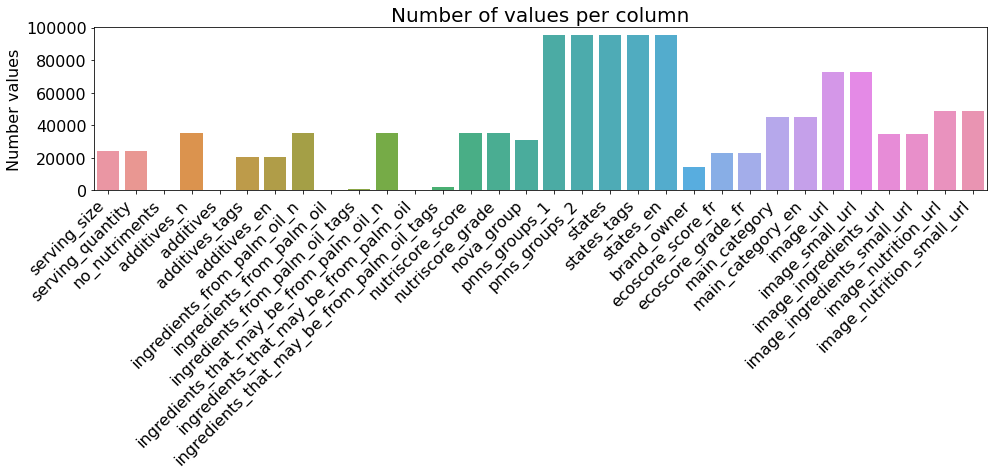

In [85]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc.columns, y=misc.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

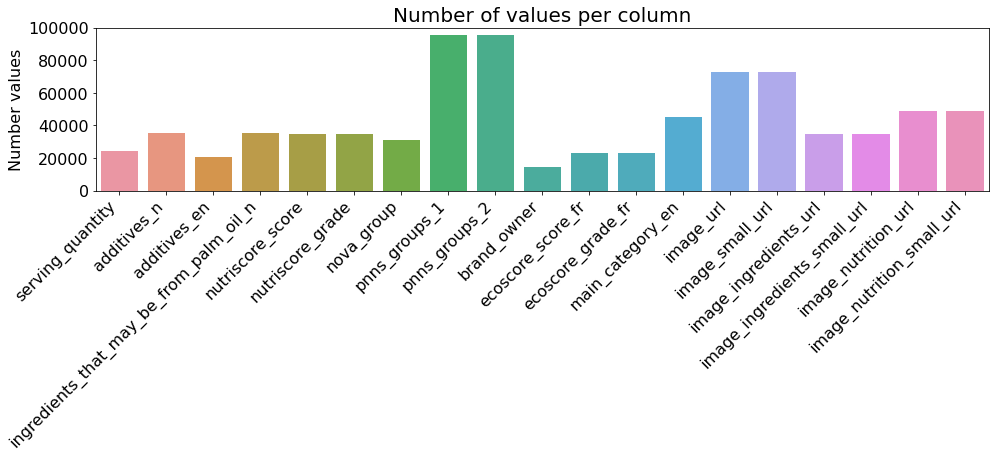

In [86]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc[misc_features].columns, y=misc[misc_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

## Nutrition facts

In [94]:
nutr = data.loc[:, "energy-kj_100g":"carnitine_100g"]

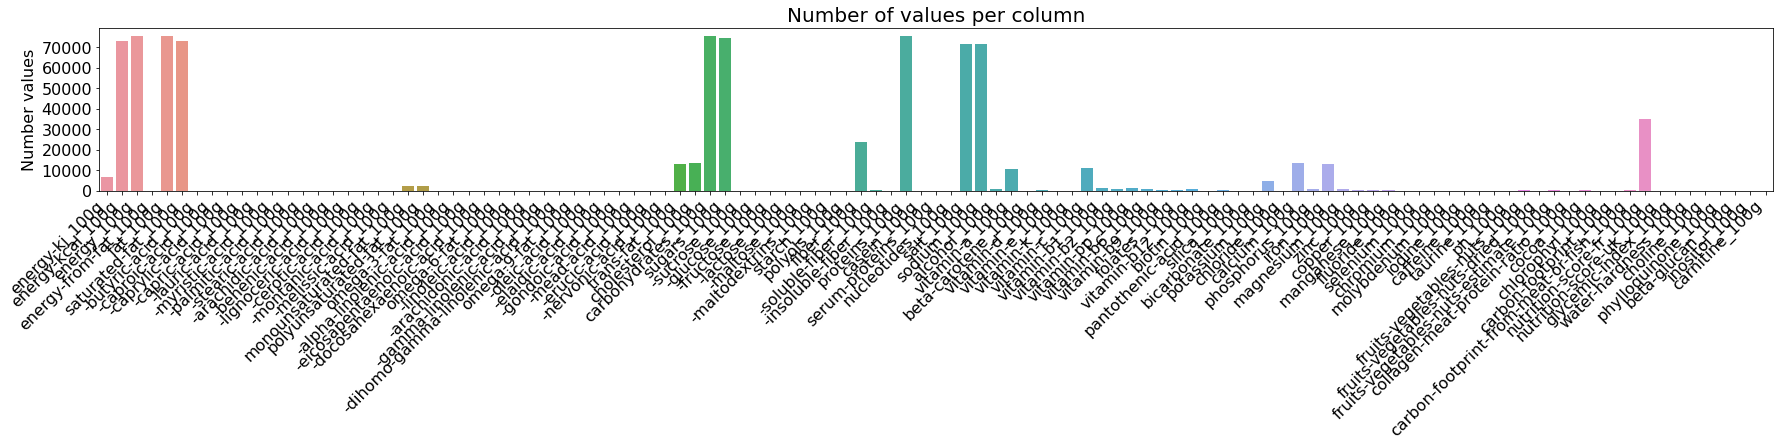

In [95]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr.columns, y=nutr.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [106]:
nutr.iloc[:, :10].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   energy-kj_100g        6854 non-null   float64
 1   energy-kcal_100g      73035 non-null  float64
 2   energy_100g           75667 non-null  float64
 3   energy-from-fat_100g  35 non-null     float64
 4   fat_100g              75308 non-null  float64
 5   saturated-fat_100g    73104 non-null  float64
 6   -butyric-acid_100g    2 non-null      float64
 7   -caproic-acid_100g    0 non-null      float64
 8   -caprylic-acid_100g   0 non-null      float64
 9   -capric-acid_100g     0 non-null      float64
dtypes: float64(10)
memory usage: 8.0 MB


In [108]:
nutr.iloc[:, 10:20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   -lauric-acid_100g      4 non-null      float64
 1   -myristic-acid_100g    1 non-null      float64
 2   -palmitic-acid_100g    1 non-null      float64
 3   -stearic-acid_100g     0 non-null      float64
 4   -arachidic-acid_100g   3 non-null      float64
 5   -behenic-acid_100g     1 non-null      float64
 6   -lignoceric-acid_100g  0 non-null      float64
 7   -cerotic-acid_100g     1 non-null      float64
 8   -montanic-acid_100g    1 non-null      float64
 9   -melissic-acid_100g    0 non-null      float64
dtypes: float64(10)
memory usage: 8.0 MB


In [109]:
nutr.iloc[:, 20:30].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   monounsaturated-fat_100g     2400 non-null   float64
 1   polyunsaturated-fat_100g     2413 non-null   float64
 2   omega-3-fat_100g             93 non-null     float64
 3   -alpha-linolenic-acid_100g   36 non-null     float64
 4   -eicosapentaenoic-acid_100g  5 non-null      float64
 5   -docosahexaenoic-acid_100g   10 non-null     float64
 6   omega-6-fat_100g             24 non-null     float64
 7   -linoleic-acid_100g          24 non-null     float64
 8   -arachidonic-acid_100g       5 non-null      float64
 9   -gamma-linolenic-acid_100g   1 non-null      float64
dtypes: float64(10)
memory usage: 8.0 MB


In [110]:
nutr.iloc[:, 30:40].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   -dihomo-gamma-linolenic-acid_100g  0 non-null      float64
 1   omega-9-fat_100g                   6 non-null      float64
 2   -oleic-acid_100g                   0 non-null      float64
 3   -elaidic-acid_100g                 0 non-null      float64
 4   -gondoic-acid_100g                 0 non-null      float64
 5   -mead-acid_100g                    1 non-null      float64
 6   -erucic-acid_100g                  0 non-null      float64
 7   -nervonic-acid_100g                1 non-null      float64
 8   trans-fat_100g                     13150 non-null  float64
 9   cholesterol_100g                   13392 non-null  float64
dtypes: float64(10)
memory usage: 8.0 MB


In [111]:
nutr.iloc[:, 40:50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carbohydrates_100g   75282 non-null  float64
 1   sugars_100g          74453 non-null  float64
 2   -sucrose_100g        9 non-null      float64
 3   -glucose_100g        5 non-null      float64
 4   -fructose_100g       4 non-null      float64
 5   -lactose_100g        45 non-null     float64
 6   -maltose_100g        4 non-null      float64
 7   -maltodextrins_100g  10 non-null     float64
 8   starch_100g          33 non-null     float64
 9   polyols_100g         165 non-null    float64
dtypes: float64(10)
memory usage: 8.0 MB


In [112]:
nutr.iloc[:, 50:60].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fiber_100g             23943 non-null  float64
 1   -soluble-fiber_100g    217 non-null    float64
 2   -insoluble-fiber_100g  192 non-null    float64
 3   proteins_100g          75355 non-null  float64
 4   casein_100g            5 non-null      float64
 5   serum-proteins_100g    4 non-null      float64
 6   nucleotides_100g       2 non-null      float64
 7   salt_100g              71706 non-null  float64
 8   sodium_100g            71706 non-null  float64
 9   alcohol_100g           1029 non-null   float64
dtypes: float64(10)
memory usage: 8.0 MB


In [113]:
nutr.iloc[:, 60:70].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vitamin-a_100g      10610 non-null  float64
 1   beta-carotene_100g  6 non-null      float64
 2   vitamin-d_100g      527 non-null    float64
 3   vitamin-e_100g      179 non-null    float64
 4   vitamin-k_100g      63 non-null     float64
 5   vitamin-c_100g      10994 non-null  float64
 6   vitamin-b1_100g     1184 non-null   float64
 7   vitamin-b2_100g     1120 non-null   float64
 8   vitamin-pp_100g     1223 non-null   float64
 9   vitamin-b6_100g     849 non-null    float64
dtypes: float64(10)
memory usage: 8.0 MB


In [114]:
nutr.iloc[:, 70:80].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vitamin-b9_100g        521 non-null    float64
 1   folates_100g           434 non-null    float64
 2   vitamin-b12_100g       698 non-null    float64
 3   biotin_100g            59 non-null     float64
 4   pantothenic-acid_100g  335 non-null    float64
 5   silica_100g            10 non-null     float64
 6   bicarbonate_100g       29 non-null     float64
 7   potassium_100g         4617 non-null   float64
 8   chloride_100g          47 non-null     float64
 9   calcium_100g           13497 non-null  float64
dtypes: float64(10)
memory usage: 8.0 MB


In [116]:
nutr.iloc[:, 80:90].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   phosphorus_100g  757 non-null    float64
 1   iron_100g        13194 non-null  float64
 2   magnesium_100g   775 non-null    float64
 3   zinc_100g        550 non-null    float64
 4   copper_100g      226 non-null    float64
 5   manganese_100g   211 non-null    float64
 6   fluoride_100g    27 non-null     float64
 7   selenium_100g    135 non-null    float64
 8   chromium_100g    8 non-null      float64
 9   molybdenum_100g  10 non-null     float64
dtypes: float64(10)
memory usage: 8.0 MB


In [117]:
nutr.iloc[:, 90:100].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   iodine_100g                           119 non-null    float64
 1   caffeine_100g                         26 non-null     float64
 2   taurine_100g                          10 non-null     float64
 3   ph_100g                               15 non-null     float64
 4   fruits-vegetables-nuts_100g           436 non-null    float64
 5   fruits-vegetables-nuts-dried_100g     14 non-null     float64
 6   fruits-vegetables-nuts-estimate_100g  560 non-null    float64
 7   collagen-meat-protein-ratio_100g      17 non-null     float64
 8   cocoa_100g                            307 non-null    float64
 9   chlorophyl_100g                       0 non-null      float64
dtypes: float64(10)
memory usage: 8.0 MB


In [118]:
nutr.iloc[:, 100:110].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   carbon-footprint_100g                    35 non-null     float64
 1   carbon-footprint-from-meat-or-fish_100g  635 non-null    float64
 2   nutrition-score-fr_100g                  34923 non-null  float64
 3   nutrition-score-uk_100g                  0 non-null      float64
 4   glycemic-index_100g                      0 non-null      float64
 5   water-hardness_100g                      0 non-null      float64
 6   choline_100g                             6 non-null      float64
 7   phylloquinone_100g                       80 non-null     float64
 8   beta-glucan_100g                         0 non-null      float64
 9   inositol_100g                            7 non-null      float64
dtypes: float64(10)
memory usage: 8.0 MB


In [119]:
nutr.iloc[:, 110:120].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 55254 to 1904342
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carnitine_100g  3 non-null      float64
dtypes: float64(1)
memory usage: 1.5 MB


### Empty features

All features that have less than 1% fill percentage will be dropped.

### Redundancy

nutrition-score-fr_100g is redundant with "nutriscore_score" and "nutriscore_grade". It will be dropped.

In [123]:
nutr_features = [
    "energy-kj_100g",
    "energy-kcal_100g",
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "monounsaturated-fat_100g",
    "polyunsaturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "alcohol_100g",
    "vitamin-a_100g",
    "vitamin-c_100g",
    "vitamin-c_100g",
    "vitamin-b1_100g",
    "vitamin-b2_100g",
    "vitamin-pp_100g",
    "calcium_100g",
    "iron_100g"
]

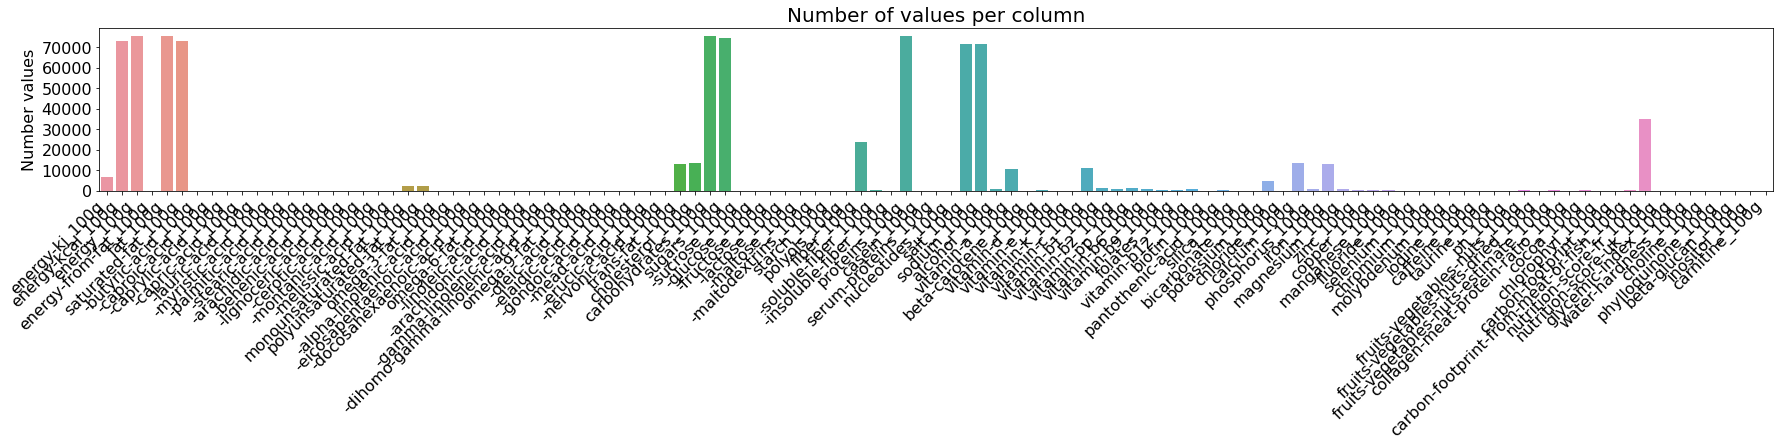

In [124]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr.columns, y=nutr.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

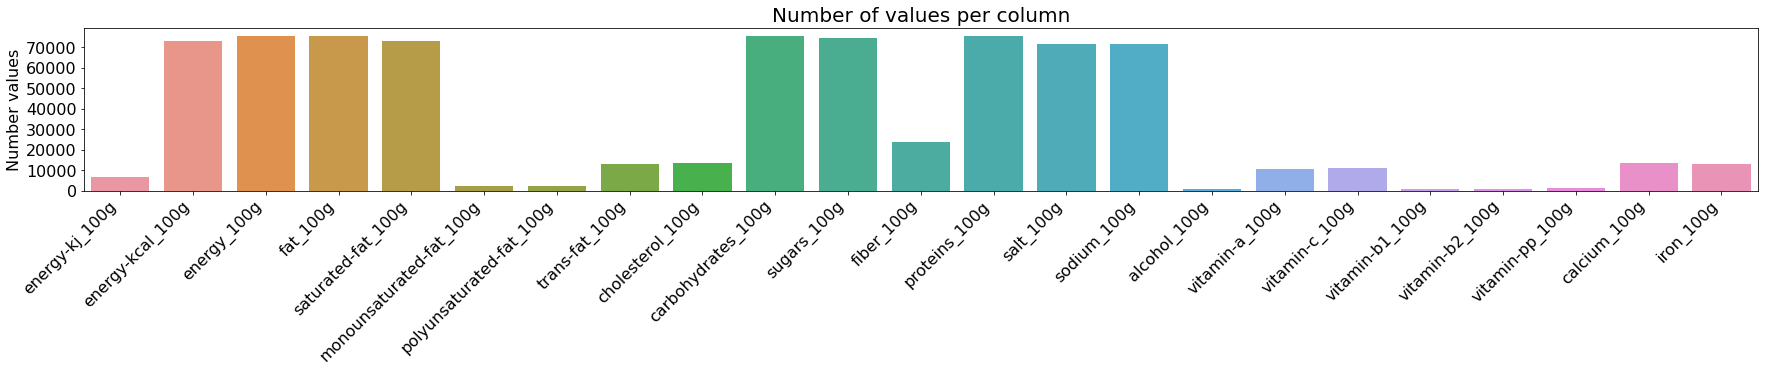

In [135]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr[nutr_features].columns, y=nutr[nutr_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

## Results

In [137]:
features = general_infos_features + tags_features + ingredients_features + misc_features + nutr_features

In [147]:
data_cleaned = data[features]

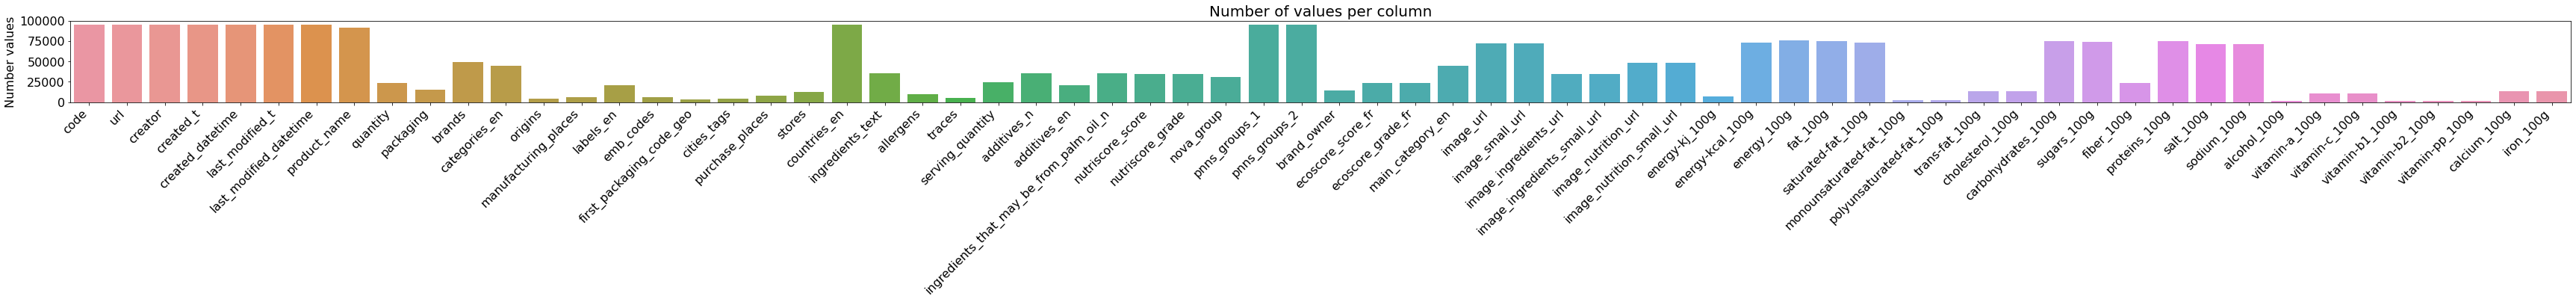

In [148]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data_cleaned.columns, y=data_cleaned.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
# Nutriscore

## Nutriscore feature analysis

In [126]:
nutriscore_features = [
    "fruits-vegetables-nuts_100g",
    "proteins_100g",
    "fiber_100g",
    "sugars_100g",
    "salt_100g",
    "saturated-fat_100g",
    "energy-kcal_100g"
]

In [127]:
nutriscore_data = data.loc[:, ["nutriscore_score", "nutriscore_grade", "nutrition-score-fr_100g"]]
nutriscore_data.head(10)

,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g
55254,20.0,e,20.0
29432,0.0,b,0.0
4008,25.0,e,25.0
9814,8.0,c,8.0
21035,-1.0,a,-1.0
97812,NaN,NaN,NaN
90159,-6.0,a,-6.0
40876,0.0,b,0.0
59776,16.0,d,16.0
94983,-4.0,a,-4.0


In [128]:
na = nutriscore_data.any(axis="columns")
print("at least one value: ", na.sum())
print("nutriscore_grade recorded: ", data.nutriscore_grade.notna().sum())
print("all rows: ", na.count())

at least one value:  34923
nutriscore_grade recorded:  34923
all rows:  95365


We can see that these threee features "nutriscore_score", "nutriscore_grade" and "nutrition-fr_100G" are redundant. Each time there is at least one of them recorded, the two others are also filled.

We can then get ride of "nutrition-fr_100g" and keep the two others.

In [129]:
features += ["nutriscore_score", "nutriscore_grade"]

Too few entries have nutriscore cell filled, around 33%.
Could be a way to calculate it manually from other fields ?

## Nutriscore needed data

Is there a way to calculate Nutriscore from the others information ?

For that, we need to have the P and N ingredients of the nutriscore formula.

P (positive) ingredients:
- fruits, vegetable, nuts
- proteins
- fiber

N (negative) ingredients:
- sugar
- salt
- saturated fatty acid
- energy (kcal)

In [130]:
p = [
    "fruit",
    "vegetable",
    "nuts",
    "olive",
    "fiber"
]

In [131]:
n = [
    "sugar",
    "sodium",
    "saturated fatr"
]

## Search for needed fields/features

In [132]:
results = []
for ingredient in p + n:
    for column in data.columns:
        if ingredient in column:
            results.append(column)
print(len(results))
results

14


['fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fiber_100g',
 '-soluble-fiber_100g',
 '-insoluble-fiber_100g',
 'sugars_100g',
 'sodium_100g']

## Nutriscore's features content analysis

They are the fields needed for the nutriscore formulas, but:
- "fruits-vegetables-nuts_100g": completely empty
- "fiber": too fews records, but could simply be due to the fact not all product contains fiber

## Where are the fruits, vegetables and nuts ?

In [133]:
pd.set_option('display.max_colwidth', None)

ingredient_text_data = data[data.ingredients_text.notna()].ingredients_text
ingredient_text_data.head(5)

55254                                                                                                                                                                                                                                                                canola oil, water, dijon mustard (vinegar, mustard seed, water, salt, white wine, citric acid, tartaric acid, spices), honey, sugar, white vinegar, apple cider vinegar, white onion powder, salt, modified tapioca starch, turmeric (for color), mustard flour, natural mustard flavor, xanthan gum, mixed tocopherols (antioxidant - vitamin e),
4008                                                                                                                                                                                       Sugar, cocoa butter, chocolate, milk, vegetable oil (palm, palm kernel), glucose syrup (from wheat), skim milk, milkfat, sweetened condensed milk, invert sugar, hazelnuts, wheat flour, dextrose, emulsifier (soya l

In [134]:
def search(row, col: str, match: list):
    for m in match:
        if m in row[col]:
            print("row[col]: ", row[col])
            # return row[col].index

data[data.ingredients_text.notna()].iloc[:10].apply(lambda row: search(row, "ingredients_text", p), axis=1)

row[col]:  Sugar, cocoa butter, chocolate, milk, vegetable oil (palm, palm kernel), glucose syrup (from wheat), skim milk, milkfat, sweetened condensed milk, invert sugar, hazelnuts, wheat flour, dextrose, emulsifier (soya lecithin, sunflower lecithin), cocoa powder processed with alkali, lactose, salt, natural and artificial flavors, cream, leavening (ammonium hydrogen carbonate, sodium carbonate, potassium carbonate).
row[col]:  Sugar, cocoa butter, chocolate, milk, vegetable oil (palm, palm kernel), glucose syrup (from wheat), skim milk, milkfat, sweetened condensed milk, invert sugar, hazelnuts, wheat flour, dextrose, emulsifier (soya lecithin, sunflower lecithin), cocoa powder processed with alkali, lactose, salt, natural and artificial flavors, cream, leavening (ammonium hydrogen carbonate, sodium carbonate, potassium carbonate).
row[col]:  Harissa sauce (water, harissa paste [bell peppers, jalapenos, canola/olive oil blend, garlic, cilantro, paprika, cumin, caraway seed, salt, c

55254    None
4008     None
9814     None
21035    None
90159    None
40876    None
59776    None
94983    None
16036    None
22163    None
dtype: object

Even if we succed to demonstrate the concentration in fruits/evetables/nuts of certain products, we still can't calculate the nutriscore because we don't have the proportion of those elements per 100g.

### Conclusion
There is now way to calculate the nutriscore.